In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline
import random
import cv2

import os
print(os.listdir("../input/gopro_large"))

# Any results you write to the current directory are saved as output.

['test', 'train']


In [2]:
    print(os.listdir("../input/gopro_large/train/GOPR0374_11_02/sharp"))

['000603.png', '000612.png', '000566.png', '000560.png', '000604.png', '000548.png', '000553.png', '000609.png', '000637.png', '000623.png', '000572.png', '000624.png', '000614.png', '000619.png', '000544.png', '000622.png', '000575.png', '000563.png', '000585.png', '000611.png', '000580.png', '000602.png', '000640.png', '000565.png', '000576.png', '000635.png', '000554.png', '000629.png', '000589.png', '000638.png', '000581.png', '000587.png', '000592.png', '000610.png', '000625.png', '000577.png', '000542.png', '000599.png', '000626.png', '000579.png', '000555.png', '000570.png', '000586.png', '000613.png', '000597.png', '000588.png', '000541.png', '000547.png', '000593.png', '000590.png', '000557.png', '000616.png', '000615.png', '000600.png', '000621.png', '000574.png', '000558.png', '000639.png', '000549.png', '000618.png', '000569.png', '000550.png', '000559.png', '000628.png', '000606.png', '000617.png', '000583.png', '000605.png', '000545.png', '000582.png', '000630.png', '0005

In [3]:
sub_dic=[]
for i in os.listdir("../input/gopro_large/train/"):
    sub_dic.append(i)
sub_dic

['GOPR0374_11_02',
 'GOPR0378_13_00',
 'GOPR0374_11_00',
 'GOPR0881_11_00',
 'GOPR0384_11_04',
 'GOPR0374_11_03',
 'GOPR0385_11_00',
 'GOPR0868_11_01',
 'GOPR0372_07_00',
 'GOPR0386_11_00',
 'GOPR0871_11_01',
 'GOPR0372_07_01',
 'GOPR0379_11_00',
 'GOPR0868_11_02',
 'GOPR0374_11_01',
 'GOPR0384_11_03',
 'GOPR0857_11_00',
 'GOPR0380_11_00',
 'GOPR0884_11_00',
 'GOPR0384_11_02',
 'GOPR0477_11_00',
 'GOPR0384_11_01']

In [4]:
 def load(path,sub_path,id_name,image_size):
        ## Path
        image_path = path+sub_path+'/sharp/'+id_name
        blur_path =  path+sub_path+'/blur/'+id_name
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size,image_size))
        
        ##Reading Blur
        
        blur = cv2.imread(blur_path)
        blur = cv2.resize(blur,(image_size,image_size))
           
        
        ## Normalizaing 
        image = image/255.0
        blur = blur/255.0
        
        return image, blur

In [5]:
def batch_load(path,sub_paths,image_size):
    image = []
    blur  = []
    
    for sub_path in sub_paths:   
        for id_name in os.listdir("../input/gopro_large/train/"+sub_path+'/sharp/'):
            _img, _blur = load(path,sub_path,id_name,image_size)
            image.append(_img)
            blur.append(_blur)
            
    image = np.array(image)
    blur  = np.array(blur)
    
    
    return image,blur

In [6]:
train_path ='../input/gopro_large/train/'
image_size =128

In [7]:
image,blur = batch_load(train_path,sub_dic,128)

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed


Using TensorFlow backend.


In [9]:
split = int((len(image)*80)/100)

In [10]:
x_train = blur[:split] 
y_train = image[:split]
x_test  = blur[split:]
y_test  = image[split:]

In [11]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


1617


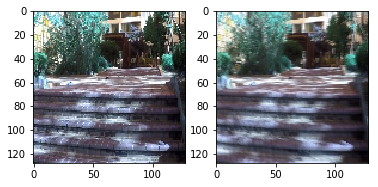

In [12]:
r = random.randint(0, len(image)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blur[r])

In [13]:
# network parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [14]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable pa

In [15]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             16842752  
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 3)       1731      
Total para

In [16]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              (None, 256)               17148288  
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       17803395  
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [17]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [18]:

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [19]:
# called every epoch
callbacks = [lr_reducer]

In [20]:
# train the autoencoder
autoencoder.fit(blur,
                image,
                validation_data=(blur, image),
                epochs=100,
                batch_size=batch_size,
                callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 2103 samples, validate on 2103 samples
Epoch 1/100
2103/2103 [==============================] - 15s 7ms/step - loss: 0.0514 - acc: 0.4071 - val_loss: 0.0383 - val_acc: 0.4028
Epoch 2/100
2103/2103 [==============================] - 8s 4ms/step - loss: 0.0327 - acc: 0.4080 - val_loss: 0.0288 - val_acc: 0.4163
Epoch 3/100
2103/2103 [==============================] - 9s 4ms/step - loss: 0.0268 - acc: 0.4138 - val_loss: 0.0245 - val_acc: 0.4067
Epoch 4/100
2103/2103 [==============================] - 9s 4ms/step - loss: 0.0231 - acc: 0.4194 - val_loss: 0.0211 - val_acc: 0.4319
Epoch 5/100
2103/2103 [==============================] - 9s 4ms/step - loss: 0.0202 - acc: 0.5288 - val_loss: 0.0187 - val_acc: 0.5945
Epoch 6/100
2103/2103 [==============================] - 9s 4ms/step - loss: 0.0178 - acc: 0.6117 - val_loss: 0.0163 - val_acc: 0.6349
Epoch 7/100
2103/2103 [==============================] - 9s 4ms/step - loss: 0.0165 - acc: 0.


 Input       Ground Truth            Predicted Value


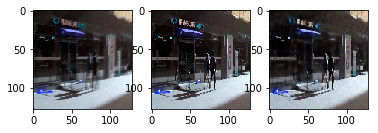

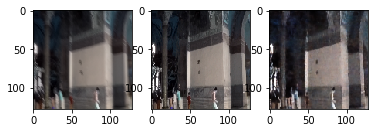

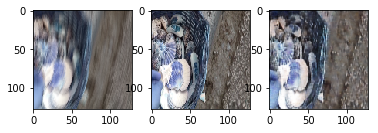

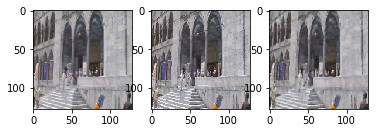

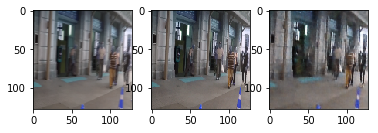

In [21]:
# Dataset for prediction
print("\n Input       Ground Truth            Predicted Value")
for i in range(5):
    
    r = random.randint(0, len(image)-1)

    x, y = blur[r],image[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)